## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Classifications


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.stats as stat
import sklearn.preprocessing as pre
import glob
import mahotas as mt
import pywt
import seaborn as sns
import pandas as pd
import csv 
import matplotlib as mpl
import time

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from mlens.ensemble import SuperLearner
from mlens.metrics import make_scorer


%matplotlib inline


[MLENS] backend: threading


## Load data

In [2]:
train_df = pd.read_csv('Data/RF_train_data.csv')
train = pd.DataFrame.as_matrix(train_df)
test = pd.DataFrame.as_matrix(pd.read_csv('Data/RF_test_data.csv'))
train_data = train[:,2:]
label_train = train[:,1]
test_data = test[:,2:]
label_test = test[:,1]
features = list(train_df.columns[2:]) 
print(np.shape(train_data))
print(np.shape(test_data))
n_ALL = 7272
n_hem = 3389
features

(10661, 16)
(1867, 16)


/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


['Cell Size',
 'Perimeter',
 'Intensity Variance',
 'Red Mean',
 'Value Mean',
 'Hue Mean',
 'Saturation Mean',
 'Blue Mean',
 'Green Mean',
 'Form Factor',
 'Intensity Mean',
 'Wavelet Approximation Mean',
 'Haralick Sum Average',
 'Boundary Roughness Variance',
 'Haralick Inverse Difference Moment',
 'Haralick Difference Variance']

# Classification

In [3]:
def accuracy(label, pred):
    """
    Calculates true positive, false positive, false negative, true negative, and Accuracy
    arg:
        label: Nx1 vector of true label
        pred: Nx1 vector of predicted labels
    return: 
        accuracy
    """
    TP,FP,TN,FN = 0,0,0,0
    for i in range(len(pred)):
        if (pred[i]==1 and label[i]==1):
            TP = TP + 1
        elif (pred[i]==1 and label[i]==0):
            FP = FP + 1
        elif (pred[i]==0 and label[i]==0):
            TN = TN + 1
        elif (pred[i]==0 and label[i]==1):
            FN = FN + 1
        else:
            print('ERROR: Different values')
    print('True Positive:  ',TP)
    print('False Positive: ',FP)
    print('True Negative:  ',TN)
    print('False Negative: ',FN)
    return (TP+TN)/(TP+TN+FP+FN)


def get_errors(prediction, label):
    """
    args:
        label: numpy array of ground truth (1 is positive, 0 is negative)
        prediction: numpy array of prediction
    returns:
        false_positive: integer of occurences of false positives
        false_negative: integer of occurences of false negatives
        true_positive: integer of occurences of true positives
        true_negative: integer of occurences of true negatives
    """
    diff = label - prediction
    false_positive = np.count_nonzero(diff == -1)
    false_negative = np.count_nonzero(diff == 1)
    total_positive = np.sum(label)
    total_negative = int(len(label) - total_positive)
    true_positive = int(total_positive - false_negative)
    true_negative = total_negative - false_positive
    print('True Positive:  ',true_positive)
    print('False Positive: ',false_positive)
    print('True Negative:  ',true_negative)
    print('False Negative: ',false_negative)
    print('Accuracy:       ', np.round((true_positive + true_negative) / 
                                       (total_positive + total_negative), decimals=3))


## Support Vector Machine (SVM)

In [4]:
# SVM
# Tuning the hyperparameters
param_grid =  {'C': [7], 'gamma': [5], 'kernel': ['rbf']}
SV_clf = GridSearchCV(svm.SVC(), param_grid, cv=5)
t0 = time.time()
SV_clf.fit(train_data, label_train)
svc_fit = time.time() - t0
print("SVM gamma and C selected and model fitted in %.2f s"
      % svc_fit)


# save the best hyperparameters
svm_c, svm_gamma = SV_clf.best_estimator_.C, SV_clf.best_estimator_.gamma

print('best score:', SV_clf.best_score_)                               
print('best C value:', svm_c)
print('best gamma value:', svm_gamma)


SVM gamma and C selected and model fitted in 17.07 s
best score: 0.857424256636338
best C value: 7
best gamma value: 5


In [5]:
# see how it works on the training data
print('SVM Results')
print('-------------------------')
print('Training Data:')
train_predictions = SV_clf.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = SV_clf.predict(test_data)
get_errors(test_predictions, label_test)

SVM Results
-------------------------
Training Data:
True Positive:   7009
False Positive:  849
True Negative:   2540
False Negative:  263
Accuracy:        0.896
 
Test Data:
True Positive:   1095
False Positive:  370
True Negative:   278
False Negative:  124
Accuracy:        0.735


## Random Forest (RF)

In [79]:
# Tuning the hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
RF_clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
RF_clf.fit(train_data, label_train)




"""
X_train, X_test, y_train, y_test = train_test_split(train_data, label_train, test_size=0.1, shuffle=True)
RF_clf = RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt")
RF_clf.fit(X_train, y_train)
y_pred=RF_clf.predict(X_test)
print("Accuracy on training data: ", metrics.accuracy_score(y_test, y_pred))
"""

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 83.0min finished


'\nX_train, X_test, y_train, y_test = train_test_split(train_data, label_train, test_size=0.1, shuffle=True)\nRF_clf = RandomForestClassifier(n_estimators=100,\n                               warm_start=True, oob_score=True,\n                               max_features="sqrt")\nRF_clf.fit(X_train, y_train)\ny_pred=RF_clf.predict(X_test)\nprint("Accuracy on training data: ", metrics.accuracy_score(y_test, y_pred))\n'

In [83]:
# print optomized parameters
print(RF_clf.best_estimator_)


# see how it works on the training data
print('RF Results')
print('-------------------------')
print('Training Data:')
train_predictions = RF_clf.predict(train_data)
get_errors(train_predictions, label_train)


# see how it works on the test data
print(' ')
print('Test Data:')
test_predictions = RF_clf.predict(test_data)
get_errors(test_predictions, label_test)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RF Results
-------------------------
Training Data:
True Positive:   7272
False Positive:  0
True Negative:   3389
False Negative:  0
Accuracy:        1.0
 
Test Data:
True Positive:   1123
False Positive:  393
True Negative:   255
False Negative:  96
Accuracy:        0.738


## K Nearest Neighbors

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [7]:
"""
Find best K values using cross validation
"""
def k_fold_test(train_data, train_label, train_index, test_index, k_value):
    KNN = KNeighborsClassifier(n_neighbors = k_value, weights="uniform", algorithm="brute") 
    KNN.fit(train_data[train_index,:], train_label[train_index])
    mean_accuracy_current_fold = KNN.score(train_data[test_index,:], train_label[test_index])
    return mean_accuracy_current_fold

def k_value_use_k_fold(train_data, train_label, k_value, kfold_nsplit):
    all_mean_accuracy = []
    kf = KFold(n_splits = kfold_nsplit, shuffle = False)
    for train_index, test_index in kf.split(train_data):
        mean_accuracy_current_fold = k_fold_test(train_data, train_label, train_index, test_index, k_value)
        all_mean_accuracy.append(mean_accuracy_current_fold)
    average_accuracy = np.round(np.mean(np.array(all_mean_accuracy)), decimals=4)
    print("{} \t {}".format(k_value, average_accuracy))
    return average_accuracy

In [8]:
"""
Actual Testing
"""
number_of_splits = 10
k_value_list = [4,6,8,9,10, 30, 50, 90, 100, 150, 200]
test_tuple_list = []
print('K val \t Avg. Accuracy')
print('--------------------------')
for k_value in k_value_list:
    average_accuracy = k_value_use_k_fold(train_data, label_train, k_value, number_of_splits)
    test_tuple_list.append((average_accuracy, k_value))
test_tuple_list.sort(reverse = True)
best_k_value = test_tuple_list[0][1]

K val 	 Avg. Accuracy
--------------------------
4 	 0.778
6 	 0.7993
8 	 0.8078
9 	 0.8188
10 	 0.8126
30 	 0.8182
50 	 0.8144
90 	 0.8101
100 	 0.8096
150 	 0.8045
200 	 0.8012


In [9]:
# Use the best K_value

print("Best K Value is {}".format(best_k_value))
print(' ')
KNN_clf = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")


# train and predict
KNN_clf.fit(train_data, label_train)
KNN_train_pred = KNN_clf.predict(train_data)
KNN_test_pred = KNN_clf.predict(test_data)


# print results
# train results
print('KNN Results')
print('-------------------------')
print('Training Data')
get_errors(KNN_train_pred, label_train)

# test results
print(' ')
print('Test Data')
get_errors(KNN_test_pred, label_test)

Best K Value is 9
 
KNN Results
-------------------------
Training Data
True Positive:   6933
False Positive:  925
True Negative:   2464
False Negative:  339
Accuracy:        0.881
 
Test Data
True Positive:   1116
False Positive:  392
True Negative:   256
False Negative:  103
Accuracy:        0.735


## Ensemble

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#import xgboost as xgb
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

seed = 2034
np.random.seed(seed)

In [11]:
# Max Voting
#create models with the optomizal hyperparameters

svc = svm.SVC(C=svm_c, gamma=svm_gamma, kernel='rbf')
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
knn = KNeighborsClassifier(n_neighbors = best_k_value, weights="uniform", algorithm="brute")



max_vote = VotingClassifier(estimators=[('svc', svc), ('rf', rf), ('knn', knn)], voting='hard')

# train and predict
max_vote.fit(train_data, label_train)
mv_train_pred = max_vote.predict(train_data)
mv_test_pred = max_vote.predict(test_data)


# print results
# train results
print('Max Voting Results')
print('-------------------------')
print('Train Data')
get_errors(mv_train_pred, label_train)

# test results
print(' ')
print('Test Data')
get_errors(mv_test_pred, label_test)


Max Voting Results
-------------------------
Train Data
True Positive:   7087
False Positive:  706
True Negative:   2683
False Negative:  185
Accuracy:        0.916
 
Test Data
True Positive:   1114
False Positive:  389
True Negative:   259
False Negative:  105
Accuracy:        0.735


In [89]:
# Bagging
kfold = model_selection.KFold(n_splits=20, random_state=1)
num_trees = 100
Bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                        n_estimators=num_trees, random_state=1)
Bag_score = model_selection.cross_val_score(Bag, train_data, label_train, cv=kfold)
print("Cross validation score: ", Bag_score.mean())
Bag.fit(train_data, label_train)
print("Accuracy on test data: ", Bag.score(test_data, label_test))
predictions = Bag.predict(test_data)
get_errors(predictions, label_test)

Cross validation score:  0.8247712755865674
Accuracy on test data:  0.7209426888055704


In [91]:
# Ada Boost 
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=1)
Ada = AdaBoostClassifier(n_estimators=num_trees, random_state=1)
Ada_score = model_selection.cross_val_score(Ada, train_data, label_train, cv=kfold)
print("Cross validation score: ", Ada_score.mean())
Ada.fit(train_data, label_train)
print("Accuracy on test data: ", Ada.score(test_data, label_test))
predictions = Ada.predict(test_data)
get_errors(predictions, label_test)

Cross validation score:  0.7836885518303672
Accuracy on test data:  0.7005891805034815
True Positive:   1035
False Positive:  375
True Negative:   273
False Negative:  184
Accuracy: 0.7005891805034815


In [92]:
# Stochastic Gradient Boosting (SGB)
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=1)
SGB = GradientBoostingClassifier(n_estimators=num_trees, random_state=1)
SGB_score = model_selection.cross_val_score(SGB, train_data, label_train, cv=kfold)
print("Cross validation score: ", SGB_score.mean())
SGB.fit(train_data, label_train)
print("Accuracy on test data: ", SGB.score(test_data, label_test))
predictions = SGB.predict(test_data)
get_errors(predictions, label_test)

Cross validation score:  0.8120155052390405
Accuracy on test data:  0.7273701124799143
True Positive:   1112
False Positive:  402
True Negative:   246
False Negative:  107
Accuracy: 0.7273701124799143


In [23]:
# Extreme Gradient Boosting (XGBoost)
XGB = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=1)
XGB = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
XGB_score = model_selection.cross_val_score(XGB, train_data, label_train, cv=kfold)
print("Cross validation score: ", XGB_score.mean())
XGB.fit(train_data, label_train)
print("Accuracy on test data: ", XGB.score(test_data, label_test))
predictions = XGB.predict(test_data)
get_errors(predictions, label_test)

Cross validation score:  0.7819044294905497
Accuracy on test data:  0.70915907873594


In [24]:
# Voting Ensemble
estimators = []
LR = LogisticRegression(solver='lbfgs', random_state=1)
estimators.append(('LR', LR))
DT = RandomForestClassifier(n_estimators=100, random_state=1)
estimators.append(('DT', DT))
SVM = SVC(kernel='sigmoid',gamma='scale',probability=True, random_state=1)
estimators.append(('SVM', SVM))
# create the ensemble model
Voting = VotingClassifier(estimators, voting = 'soft',weights=[1, 1, 5])
Vot_score = model_selection.cross_val_score(Voting, train_data, label_train, cv=kfold)
print("Cross validation score: ", Vot_score.mean())
Voting.fit(train_data, label_train)
print("Accuracy on test data: ", Voting.score(test_data, label_test))

Cross validation score:  0.7050747216072838
Accuracy on test data:  0.6652383502945902


In [ ]:
# Stacking
ensemble = SuperLearner(scorer=accuracy_score, random_state=seed, verbose=2)

# Build the first layer
ensemble.add([RandomForestClassifier(random_state=seed), svm.SVC()])

# Attach the final meta estimator
ensemble.add_meta(LogisticRegression())

# Fit ensemble
ensemble.fit(train_data, label_train)

# Predict train data
preds = ensemble.predict(train_data)

### ROC Curve

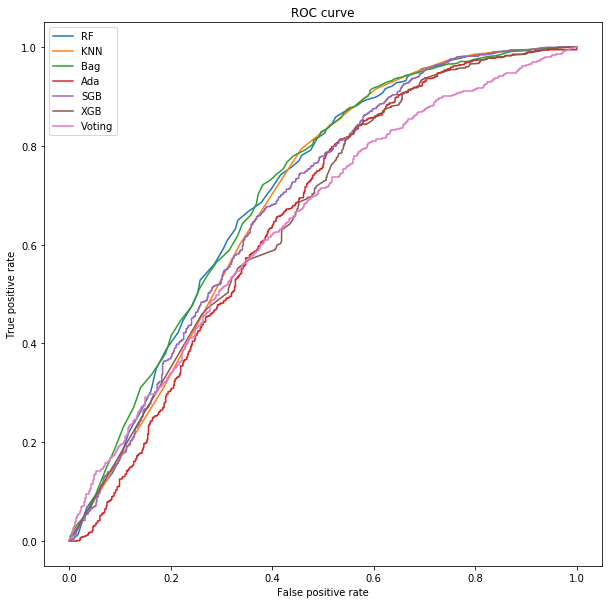

In [25]:
from sklearn.metrics import roc_curve
RF_prob = RF_clf.predict_proba(test_data)[:,1]
FPR_RF, TPR_RF, _ = roc_curve(label_test, RF_prob)
KNN_prob = KNN.predict_proba(test_data)[:,1]
FPR_KNN, TPR_KNN, _ = roc_curve(label_test, KNN_prob)
Bag_prob = Bag.predict_proba(test_data)[:,1]
FPR_Bag, TPR_Bag, _ = roc_curve(label_test, Bag_prob)
Ada_prob = Ada.predict_proba(test_data)[:,1]
FPR_Ada, TPR_Ada, _ = roc_curve(label_test, Ada_prob)
SGB_prob = SGB.predict_proba(test_data)[:,1]
FPR_SGB, TPR_SGB, _ = roc_curve(label_test, SGB_prob)
XGB_prob = XGB.predict_proba(test_data)[:,1]
FPR_XGB, TPR_XGB, _ = roc_curve(label_test, XGB_prob)
Vot_prob = Voting.predict_proba(test_data)[:,1]
FPR_Vot, TPR_Vot, _ = roc_curve(label_test, Vot_prob)


plt.figure(1, figsize = (10,10))
plt.plot(FPR_RF, TPR_RF, label='RF')
plt.plot(FPR_KNN, TPR_KNN, label='KNN')
plt.plot(FPR_Bag, TPR_Bag, label='Bag')
plt.plot(FPR_Ada, TPR_Ada, label='Ada')
plt.plot(FPR_SGB, TPR_SGB, label='SGB')
plt.plot(FPR_XGB, TPR_XGB, label='XGB')
plt.plot(FPR_Vot, TPR_Vot, label='Voting')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 